Для чтения las-файлов существует открытая библиотека - lasio

In [1]:
import pandas as pd
import plotly.express as px

import lasio

https://lasio.readthedocs.io/en/latest/index.html

In [13]:
dir_data = "omsk"
file_name = "g288.las"

In [14]:
las = lasio.read(f"{dir_data}/{file_name}")

DEPT .m                   : DEPTH - глубина по стволу скважины

BK .ohm.m                 : BK - боковой каротаж сопротивления

NKT .m3/m3                : NKT - нейтронный каротаж

IK .mS/m                  : IK - индукционный каротаж

GK .gAPI                  : GK - гамма каротаж

SP .mV                    : SP - каротаж самопроизвольной поляризации

RT .ohm.m                 : RT - каротаж сопротивления

https://geoznanie.ru/geofizika/obrabotka-las-fajlov-s-pomoshhyu-python/?

In [16]:
dic_gis = {}
dic_gis["dept"] = las["DEPT"]
dic_gis["bk"] = las["BK"]
dic_gis["nkt"] = las["NKT"]
dic_gis["ik"] = las["IK"]
dic_gis["gk"] = las["GK"]
dic_gis["sp"] = las["SP"]
dic_gis["rt"] = las["RT"]


df_gis = pd.DataFrame(dic_gis)
#df_gis

In [17]:
fig = px.line(df_gis, x="dept", y = ["bk", "nkt", "ik", "gk", "sp", "rt"])
fig.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 5))
plt.title('Загруженные данные ГИС')
color = 'tab:red'
ax1.set_xlabel("Глубина (MD), м")
ax1.set_ylabel("dGR, у.е.", color=color)
ax1.plot(dept, dgr, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:green'
ax2.set_ylabel("aPS, у.е.", color=color)
ax2.plot(dept, aps, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
#plt.legend(loc='upper right')

fig.tight_layout() 
plt.xlim(1550, 1900)
plt.show()

## Загрузка 2D данных

Данные в формате XYZ так же можно загружать как txt-массив

In [ ]:
map_grid = np.loadtxt('anon_map_points.txt')
points = np.loadtxt('anon_well_points.txt')

In [ ]:
map_grid.shape, points.shape

сохраним координаты в отдельные массивы

In [ ]:
pointx = points.T[0]
pointy = points.T[1]
gridx = map_grid.T[0]
gridy = map_grid.T[1]

Для визуализации данных в формате XYZ можно выполнять поточечное отображение - в этом случае координаты передаются в виде 1D массивов, порядок в каждом массиве согласован с остальными

In [ ]:
plt.figure(figsize=(5,10))
plt.scatter(x=map_grid[:,0],y=map_grid[:,1],c=map_grid[:,2],s=0.02,cmap='hsv')
for i in range(len(pointx)):
    plt.plot(pointx[i],pointy[i], color='black', marker='o',markersize=3)
plt.title('Загруженные данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('scaled')
plt.tight_layout()
plt.colorbar(shrink=0.25)

## Операции с точками

В точках скважин записано два атрибута. Отобразим их зависимость друг от друга

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(points[:,2], points[:,3], '*r')
plt.grid()
plt.xlabel('Глубина')
plt.ylabel('Ошибка')

In [ ]:
from scipy import stats

x = points[:,2] # значения глубины
y = points[:,3] # значения ошибки валидации

slope, intercept, rvalue = stats.linregress(x, y)[0:3] # подбор регрессии

y_est = intercept + slope*x # прогноз по значениям х

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(x, y, 'or', label='данные')
plt.plot(x, y_est, 'k', label='модель')
plt.title('Коэффициент корреляции = %.2f' % rvalue)
plt.xlabel('Глубина, м')
plt.ylabel('Ошибка валидации, м')
plt.grid(ls=':',alpha=.5)
plt.legend()
plt.show()

Зависимость обусловлена единственный "отлетающей" скважиной.
Выполним валидацию, чтобы показать как меняется коэффициент корреляции

In [ ]:
np.argwhere(y==y.max()) # функция позволяет определить позицию в массиве, соответсвующую заданному условию

In [ ]:
y[4], x[4]

Создадим новые массивы, без "отлетающей" скважины и повторим вычисления

In [ ]:
'''
функция filter позволяет фильтровать массив по заданной функции.

lambda - однострочная функция
'''

x_n = list(filter(lambda t : t != x[4], x))
y_n = list(filter(lambda x : x != y[4], y))

In [ ]:
slope, intercept, rvalue = stats.linregress(x_n, y_n)[0:3] # подбор регрессии

y_est = intercept + slope*x # прогноз по значениям х

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(x, y, 'or', label='данные')
plt.plot(x_n, y_n, 'oy', label='данные (с исключением скважины)')
plt.plot(x, y_est, 'k', label='модель')
plt.title('Коэффициент корреляции = %.2f' % rvalue)
plt.xlabel('Глубина, м')
plt.ylabel('Ошибка валидации, м')
plt.grid(ls=':',alpha=.5)
plt.legend()
plt.show()

## Задание #2

Проведите исследование по устойчивости линейной регрессии - выполните последовательное исключение скважин с оценкой Ккор.
- Подумайте, как визуализировать результаты анализа;
- Какой критерий мог бы использоваться для заключения об устойчивости регрессии?

Результат:
- В рамках блокнота создайте функцию, которая берет на вход набор точек [X1, X2]. В рамках функции выполняется поочередное исключение точек с оценкой коэффициента корреляции.
- На выходе функции - набор коэффициентов корреляции при исключении каждой скважины.
- Подберите наглядный способ визуализации для принятия решения об устойчивости/неустойчивости регрессии

## Операции с картами

Создадим карту, каждая точка которой показывала бы расстояние до ближайшей скважины

In [ ]:
new_map = np.zeros(map_grid.shape)

new_map[:,0], new_map[:,1] = map_grid[:,0], map_grid[:,1]

__Формализуем задачу:__ 

мы хотим чтобы каждая точка карты отражала расстояние до ближайшей скважины.

__Шаги:__

- перебираем все точки карты;
- для выбранной точки считаем расстояние до всех скважин;
- определяем минимальное зачения расстояния;
- сохраняет его как значение карты.

In [ ]:
for i in range(map_grid.shape[0]):
    d = []
    for j in range(points.shape[0]):
        d.append(((gridx[i]-pointx[j])**2 + (gridy[i]-pointy[j])**2)**0.5)
    dd = min(d)
    
    new_map[i,2] = dd

In [ ]:
plt.figure(figsize=(5,10))
plt.scatter(x=map_grid[:,0],y=map_grid[:,1],c=new_map[:,2],s=0.02,cmap='terrain')
for i in range(len(pointx)):
    plt.plot(pointx[i],pointy[i], color='black', marker='o',markersize=3)
plt.title('Рассчитанная карта')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('scaled')
plt.tight_layout()
plt.colorbar(shrink=0.25)

In [ ]:
np.savetxt('new_map.txt', new_map) # сохраним результаты в txt-файл

## Задание #3

В точках даны значения ошибки валидации - points[:,3];

Проанализируйте связь между ошибкой валидации и расстоянием до ближайшей скважины.
Дайте обоснованный ответ можно ли использовать посчитанную ранее карту для моделирования потенциальной ошибки.

Результат:
- отдельный блокнот с расчетами
- оцените удаленность каждой скважины
- покажите зависимость ошибка-удаленность
- обоснуйте вывод о возможности/невозможности использования этого критерия

## Задание #4*

Имеющаяся карта (map_grid) описывает структуру (глубину залегания) одного из пластов. Проведите анализ связи ошибик валидации с углом наклона поверхности.

Результат:
- отдельный блокнот;
- функция оценки углов наклона (допустимо в одном из направлений);
- *оцените есть ли корреляция ошибки валидации в точках скважин со значением угла наклона (допустимо взять ближйшее к скважине значнеие с карты)
- при наличи зависимости вычислите карту прогнозной ошибки.

## Загрузка 3D данных (SEG-Y)

Сейсмический файл в Python будет представлять из себя трехмерную матрицу (массив) значений (амплитуд).

В таком представлении у нас теряется информация о пространственной привязки отдельных дискретов (как в плоскости X-Y, так и по оси Z). Поэтому необходимо отдельно сохранять информацию о пространственной привязке данных

Файл SGY содержит всю эту информацию в заголовках трасс, поэтому нам необходимо сохранить ее отдельно, что бы иметь возможность интерпретировать наши данные в Python.

Из-за того, что SGY-файл имеет бинарный формат, его считывание в Python является нетривиальной задачей – необходимо перевести значения из бинарного формата в числовой, а также извлечь информацию из заголовков. Эту задачу решают внешние библиотеки – программы, написанные другими исследователями, которые они выложили в открытый доступ (внутренние библиотеки Python аналогично написаны кем-то, однако они уже заранее установлены).


Для загрузки SGY файлов могут быть использованы готовые библиотеки - segyio, segpy

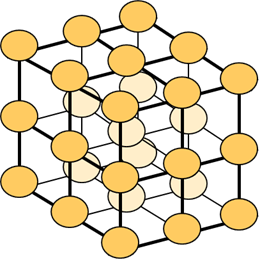

In [ ]:
import segyio

In [ ]:
amp = segyio.tools.cube('TrainingData_Image.segy') # загрузка куба
vminmax = np.max([np.abs(amp.min()),np.abs(amp.max())]) # определение абсолютного максимального значения амплитуды

In [ ]:
amp.shape # выводим размер массива

In [ ]:
plt.imshow(amp[250,:,:]) # эта функция позволяет визуализировать 2Д массивы

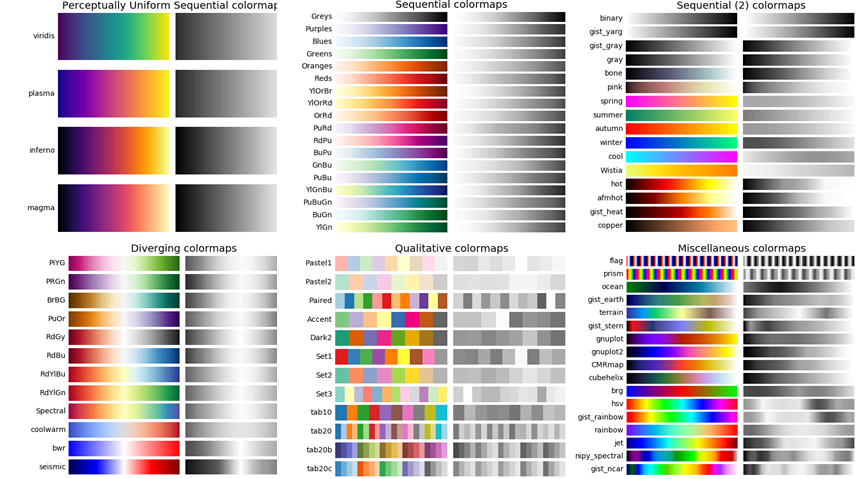

In [ ]:
plt.figure(dpi=300) # создание иллюстрации
plt.imshow(amp[250,:,:].transpose(), cmap='seismic', vmin=-0.5*vminmax, vmax=0.5*vminmax, aspect='auto')
plt.colorbar() # добавление шкалы
plt.title("срез по inline") # подпись
plt.grid(ls=':',alpha=.5) # сетка
plt.xlabel('xline') # подпись оси X
plt.ylabel('TWT') # подпись оси Y

In [ ]:
# заменим цветовую схему
plt.figure(dpi=300)
plt.imshow(amp[:,300,:].transpose(), cmap=plt.cm.PuOr, vmin=-.25*vminmax, vmax=.25*vminmax, aspect='auto')
plt.colorbar()
plt.title("срез по xline")
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('TWT')

In [ ]:
plt.figure(dpi=200)
plt.imshow((amp[:,:,200]), cmap=plt.cm.RdGy, vmin=-1.0*vminmax, vmax=vminmax)
plt.colorbar()
plt.title("срез по TWT")
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()

# Резюме


Python поволяет считывать большинство данных, от текстовых до бинарных SEG-Y файлов. Для дальнейшей работы данные преобразуются в Numpy массивы.

библиотеки:
- lasio - библиотека для работы с las-файлами
- segyio - библиотека для работы с SEG-Y файлами

функции:
- np.loadtxt - загрузка текстового файла
- plt.scatter - визуализация точечных данных
- np.argwhere - возвращает позицию элемента в списке, удовретворяющего заданному условию
- filter - рименение функции к элементам списка
- lambda - строчная функция
- append - добавление элемента в список
- min() - возвращает минимальное значение в списке
- np.savetxt - сохранение текстового файла

# Операции по трассам (single-trace attributes)

In [ ]:
amp = segyio.tools.cube('seis.sgy') # внешний файл куба
vminmax = np.max([np.abs(amp.min()),np.abs(amp.max())]) # определение абсолютного максимального значения амплитуды
amp.shape # выводим размер массива

Библиотека segyio позволяет считывать заголовки, проводить над ними операции, а также создавать SEG-Y файлы.

Попробуем считать текстовый заголовок нашего файла:

In [ ]:
with segyio.open('seis.sgy', mode="r") as f:
    raw_header = segyio.tools.wrap(f.text[0])
    cut_header = raw_header.split('\n')

In [ ]:
cut_header

Отсюда мы можем взять информацию о размерности нашего куба - истиных номерах inline, xline, а также о начальном времени

другие примеры:

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=c93e02027ea31d699b65be611f2747cc78cc967e&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f657175696e6f722f73656779696f2d6e6f7465626f6f6b732f633933653032303237656133316436393962363562653631316632373437636337386363393637652f6e6f7465626f6f6b732f62617369632f30325f736567795f717569636b6c6f6f6b2e6970796e62&logged_in=false&nwo=equinor%2Fsegyio-notebooks&path=notebooks%2Fbasic%2F02_segy_quicklook.ipynb&platform=android&repository_id=174579549&repository_type=Repository&version=98

### Теперь внешний сейсмический куб является массивом numpy - мы можем производить над его элементами различные операции.

__Создадим функцию для вычисления RMS значения в скользящем окне:__
- функция должна брать на вход трассу;
- вычислять среднеквадратическое значение с заданном окне;
- сохранять это значение в дискрет, соответствующий центру окна.


## $\ RMS = \sqrt{ \frac{\sum\limits_{i=1}^{n} a^2}{n} }\ $

In [ ]:
# Создадим функцию для вычисления RMS-трассы

def rms_comp(trace, win):
    new_trace = np.zeros(len(trace)+win*2) # создаем шаблон для записи с учетом ширины окна
    new_trace[win:-win] = trace # копируем трассу в шаблон - теперь сверху и снизу нулевые значения по ширине окна

    rms_trace = np.zeros(len(trace)+win*2) # шаблон для записи результата
    
    # перебор по времени - т.е. создаем скользящее окно
    for i in range(len(trace)):
        rms_trace[win+i] = (sum(new_trace[i:2*win+i+1]**2)/(2*win+1))**0.5 
        # вычисляем сумму квадратов, среднее и извлекаем корень = среднеквадратическое значение

    rms_trace = rms_trace[win:-win]
    return rms_trace # функция возвращает RMS-трассу

# функции в дальнейшем можно применять к массивам

Применим функцию к каждой трассе нашего куба

In [ ]:
import time

In [ ]:
start1 = time.time()

rms_seis = np.zeros(amp.shape) # пустой массив для записи результатов

# организуем перебор по всем трассам
for i in range(amp.shape[0]):
    for j in range (amp.shape[1]):
        rms_seis[i,j,:] = rms_comp(amp[i,j,:], win = 3) # применение функции при переборе всех трасс
        
print ('--- %.2f sec ---' % (time.time()-start1))

--- 254.40 sec ---

In [ ]:
start1 = time.time()

rms_seis = np.array([rms_comp(x, win=3) for x in amp.reshape(amp.shape[0]*amp.shape[1],amp.shape[2])]).reshape(amp.shape)


print ('--- %.2f sec ---' % (time.time()-start1))

--- 258.39 sec ---

Оба варианта занимают примерно одинаковое количество времени. Субьективно, первый вариант проще понять на визуальном уровне при чтении кода. Второй вариант - более компактный.

In [ ]:
plt.figure(dpi=150)

plt.imshow(amp[500,:,:].transpose(), cmap=plt.cm.seismic, vmin=-1.0*vminmax, vmax=vminmax, aspect='auto')
plt.colorbar()
plt.title("срез по inline")
plt.grid(ls=':',alpha=.5)
plt.xlabel('xline')
plt.ylabel('TWT')

plt.figure(dpi=150)
plt.imshow(rms_seis[500,:,:].transpose(), cmap=plt.cm.jet, aspect='auto')
plt.colorbar()
plt.title("срез по inline")
plt.grid(ls=':',alpha=.5)
plt.xlabel('xline')
plt.ylabel('TWT')

# Загрузка отражающего горизонта

In [ ]:
# это априорная информация из текстового заголовка SEG-Y (см. выше)

finl = 479 #Номер первого inline
fcrl = 5000 #Номер первого xline
tmin = 1750 #Время первого дискрета
tinc = 2 #Шаг дискретизации

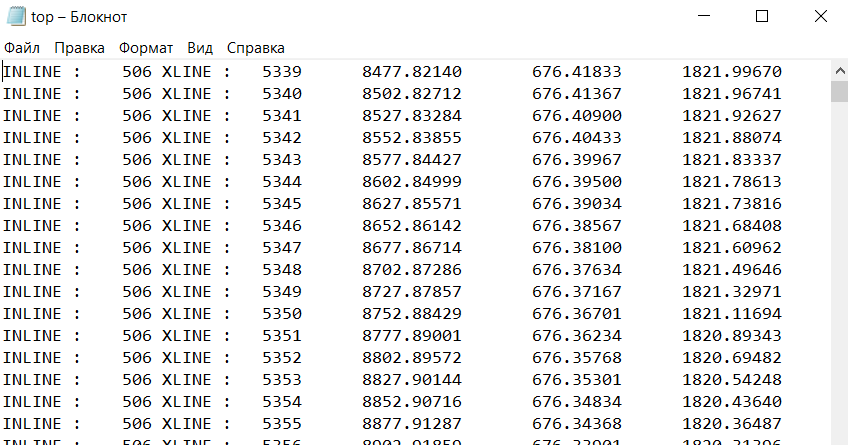

In [ ]:
top = np.loadtxt('top.char', usecols=(2,5,6,7,8)) # загрузка внешнего файла ОГ
# ограничим набор столбцов - т.к. данная функция не работает с текстовыми полями

In [ ]:
top[0] # вывод первой строки массива

In [ ]:
amp.shape, top.shape

In [ ]:
ninl = np.rint(top[:,0]-finl).astype(np.int) # массив с номерами inline
ncrl = np.rint(top[:,1]-fcrl).astype(np.int) # массив с номерами xline
x_coor = top[:,2] # массив с координатами X
y_coor = top[:,3] # массив с координатами Y

t_top = top[:,4] # массив значений времени

In [ ]:
t_top

In [ ]:
t_hor_top = (t_top-tmin)/tinc # перевод из значений времени в мс в номера дискретов

horizon_top = np.zeros((amp.shape[0],amp.shape[1])) # шаблон для записи карты по размеру куба
mask = np.zeros((amp.shape[0],amp.shape[1]))

horizon_top[ninl[:],ncrl[:]] = t_hor_top[:].copy() # записываем фактические значения в шаблон
mask[ninl[:],ncrl[:]] = 1

In [ ]:
t_hor_top

In [ ]:
plt.figure(dpi=200)
plt.imshow((horizon_top), cmap='terrain')
plt.colorbar()
plt.title("срез по TWT")
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()

In [ ]:
plt.figure(dpi=150)
plt.imshow(amp[500,:550,:].transpose(), 
           cmap=plt.cm.seismic, 
           vmin=-1.0*vminmax, 
           vmax=vminmax, 
           aspect='auto')

plt.plot(horizon_top[500,:550], '--m')

plt.colorbar()
plt.title("срез по inline")
plt.grid(ls=':',alpha=.5)
plt.xlabel('xline')
plt.ylabel('TWT')

# Анализ амплитуд

In [ ]:
# расчет RMS в окне вдоль ОГ
rms_slice = np.zeros((amp.shape[0],amp.shape[1]))

win = 10 # окно расчета

for i in range(amp.shape[0]):
    for j in range(amp.shape[1]):
        if horizon_top[i,j] != 0:
            t1 = (horizon_top[i,j]).astype(int)
            
            rms_slice[i,j] =  (np.mean((amp[i,j,t1:t1+win])**2))**0.5

In [ ]:
plt.figure(dpi=200)
plt.imshow(rms_slice, cmap='twilight_r')
plt.colorbar()
plt.title("RMS амплитуда в интервале пласта")
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()

## Анализ со скважинными данными

In [ ]:
well_data = np.loadtxt('ini_points_anon.txt') # загрузка скважинной информации

In [ ]:
well_data

Извлечем значения с карты в точки скважин. Так как координаты точек грида и точек скважин в общем случае не совпадают, необходимо выработать алгоритм вычисления значений карты в точках скважин.

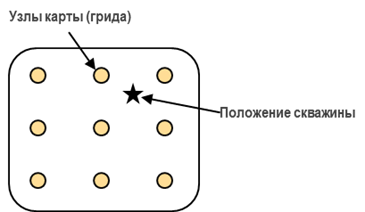

#### Реализуем свой метод IDW-интерполяции

In [1]:
plt.figure(figsize=(15,10))
plt.scatter(x_coor, y_coor, c=rms_slice[ninl[:],ncrl[:]], vmax=2500, cmap='hsv')
for i in range(well_data.shape[0]):
    plt.plot(well_data[i,0],well_data[i,1], color='black', marker='o',markersize=6)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('scaled')
plt.tight_layout()
plt.colorbar()
plt.grid(ls=':',alpha=.5)

NameError: name 'plt' is not defined

Взвешивание обратного расстояния (IDW) - это тип детерминированного метода для многомерной интерполяции. Значения, присвоенные неизвестным точкам, вычисляются с использованием средневзвешенного значений, доступных в известных точках.


https://en.wikipedia.org/wiki/Inverse_distance_weighting

In [ ]:
amp_map = rms_slice[ninl[:],ncrl[:]] # оставим значения карты, определенные по гриду ОГ 
                                     # (т.к. в ОГ у нас есть информация о координатах)

plot = [] # пустой массив для сохранения результата

inf_r = 50 # радиус влияния на точки. Этот параметр может варьироваться

# перебор по скважинам из загруженного файла
for i in range(well_data.shape[0]):
    x_well = well_data[i][0] # сохраняем координаты скважин
    y_well = well_data[i][1] # сохраняем координаты скважин
    
    dist = np.zeros((len(x_coor),2)) # массив для сохранения расстояний
    
    for j in range(len(x_coor)):
        # вычисляем расстояния от точек скважин до узлов карты
        dist[j,0] = ((x_coor[j]-float(x_well))**2 + (y_coor[j]-float(y_well))**2)**0.5
        
        # сохраняем значение с карты
        dist[j,1] = amp_map[j]
    
    inf_points = [] # список влияющих точек
    
    # делаем отсечку по влияющему радиусу
    for k in range(len(x_coor)):
        if dist[k,0] < inf_r:
            inf_points.append(dist[k,:]) # кидаем точку в список
            
    # переводим в массив
    inf_points = np.array(inf_points)
    
    well_time = 0
    norm = 0
    
    # задаем интерполяцию обратно расстоянию
    for m in range(inf_points.shape[0]):
        well_time += (1/inf_points[m,0])*inf_points[m,1]
        norm += (1/inf_points[m,0])
    
    # чтобы избежать деления на 0
    if norm != 0:
        well_time = well_time/norm
        
        plot.append([float(well_data[i][2]),well_time])
к
plot = np.array(plot) 

В данном случае, решение наглядное, но не оптимальное - возникает необходимость масштабного перебора. При увеличении количества скважин, такой подход будет занимать много времени

In [ ]:
plot

Используем известное решение по поиску линейной регрессии

In [ ]:
from scipy import stats

x = plot[:,1] # значения карты
y = plot[:,0] # значения в скважинах

slope, intercept, rvalue = stats.linregress(x, y)[0:3] # подбор регрессии

y_est = intercept + slope*x # прогноз по карте амплитуд

# ошибка регрессионной модели
std_model = (y-y_est)**2
std = ((sum(std_model))/len(y))**0.5

errors = y-y_est

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(x, y, 'or', label='данные')
plt.plot(x, y_est, 'k', label='модель')
plt.title('Коэффициент корреляции = %.2f' % rvalue)
plt.xlabel('RMS амплитуда')
plt.ylabel('Эффективная мощность, м')
plt.grid(ls=':',alpha=.5)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(errors, bins=5, histtype='stepfilled', density=True, color='k', alpha=0.75)
plt.xlabel('Ошибка модели, м')
plt.title('Оценка STD: %f' % std)
plt.grid(ls=':',alpha=.5)
plt.show()

Применим уравнение к карте амплитуд:

In [ ]:
hef = slope*rms_slice+intercept
hef = hef.reshape((amp.shape[0],amp.shape[1]))

In [ ]:
plt.figure(dpi=200)
plt.imshow(hef, cmap=plt.cm.Oranges, vmin = 0, vmax = hef.max()*0.65)
plt.colorbar()
plt.title("Прогноз эффективной мощности, м")
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()

### В следующий раз мы обсудим более сложные атрибуты и способы их получения из сейсмичсеких данных

__Выполните задания #2, #3 и #4*__